# Lecture 6
## The spatial coalescent/simulating whole genomes

## The spatial algorithm
So far we have thought about the coalescent tree/ARG as running backwards in time. Now we are going to introduce an important alternative perspective due to Wiuf and Hein (1999), which lets us generate ARGs from left to right, as we move along the chromosome.

Note: this algorithm might seem rather hard to understand at first. See GVE §5.5.2 for an intuitive explanation.

The algorithm works as follows. Suppose that we are shown the following ARG (Durrett p.102):

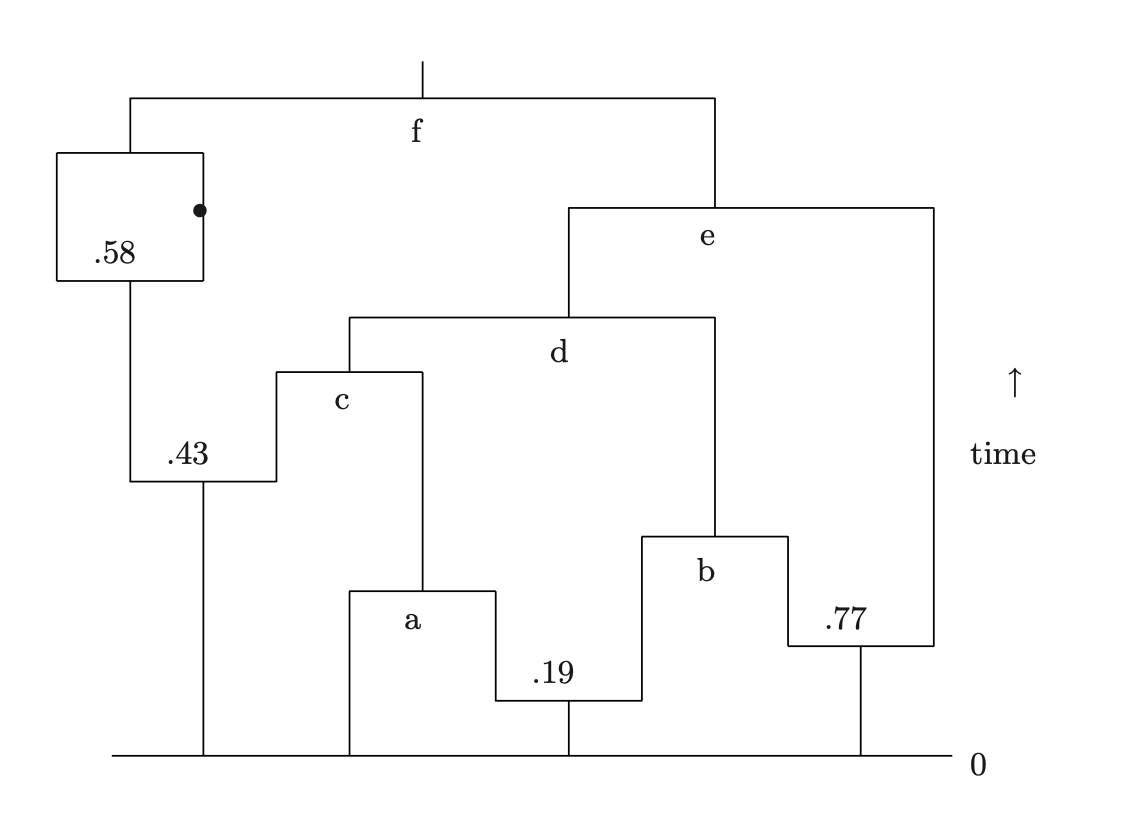

The genealogy for positions $[0,.19)\times L$ (where $L$ is the length of the overall sequence) is given by following each recombination event leftwards:

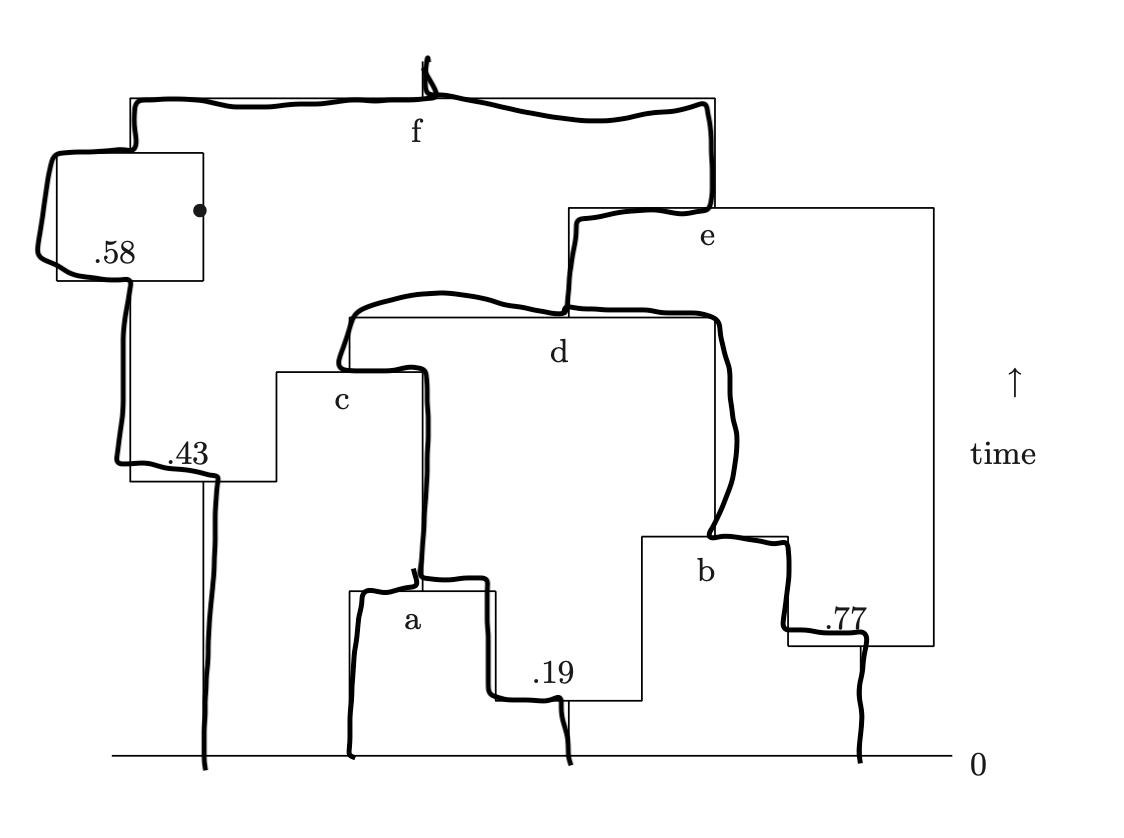

Conditional on this tree, what is the distribution of the location of the first recombination breakpoint (in this case, $0.19L$)?

Let the total branch length in the entire tree be $2Nb$ generations. The number of recombinations $n$ that occurs in these sequences is binomially distributed: 
$$p(n) \sim \operatorname{Binom}(n;2NbL,r),$$
where $r\ll1$ is the probability of a recombination at each position per generation.

Now, we will assume that $N,L\to\infty$ and $r\to 0$, such that $\lim 4LNr = \rho$. The parameter $\rho$ is called the *population-scaled recombination rate*; it's (twice) the expected number of recombinations that occur in one unit of coalescent time $2N$.

Then 

$$p(n) \sim \operatorname{Poisson}(n;b\rho/2).$$

As $\rho\to\infty$, this says that recombinations form a Poisson process with intensity $b$. In particular, the distance to the first recombination event is $\sim \mathrm{Exponential}(b)$, and its location is uniformly distributed along the branches of the existing tree. (Note that the sequence length measured by this exponential random variable has units of $\rho/2$, i.e. the expected number of recombinations per $2N$ generations.)

Given that we arrived at the first recombination break point, what happens? Let's us consider the simple example of a coalescent tree with 2 leaves:

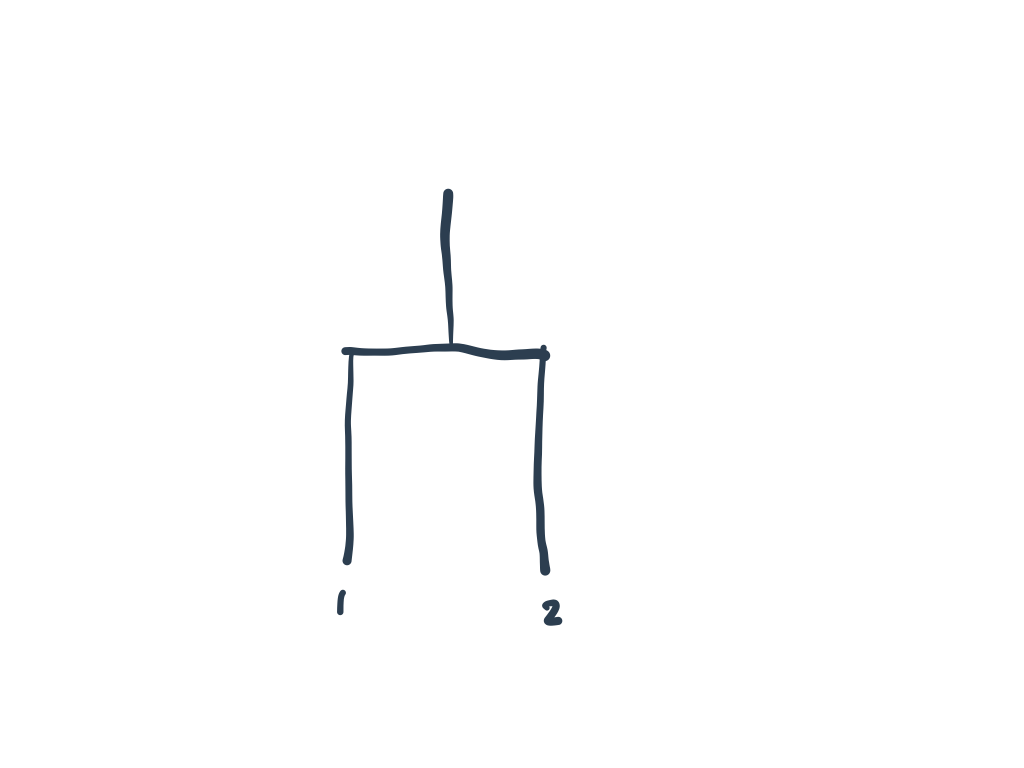

We perform the procedure above, and draw a recombination breakpoint at position $2$.

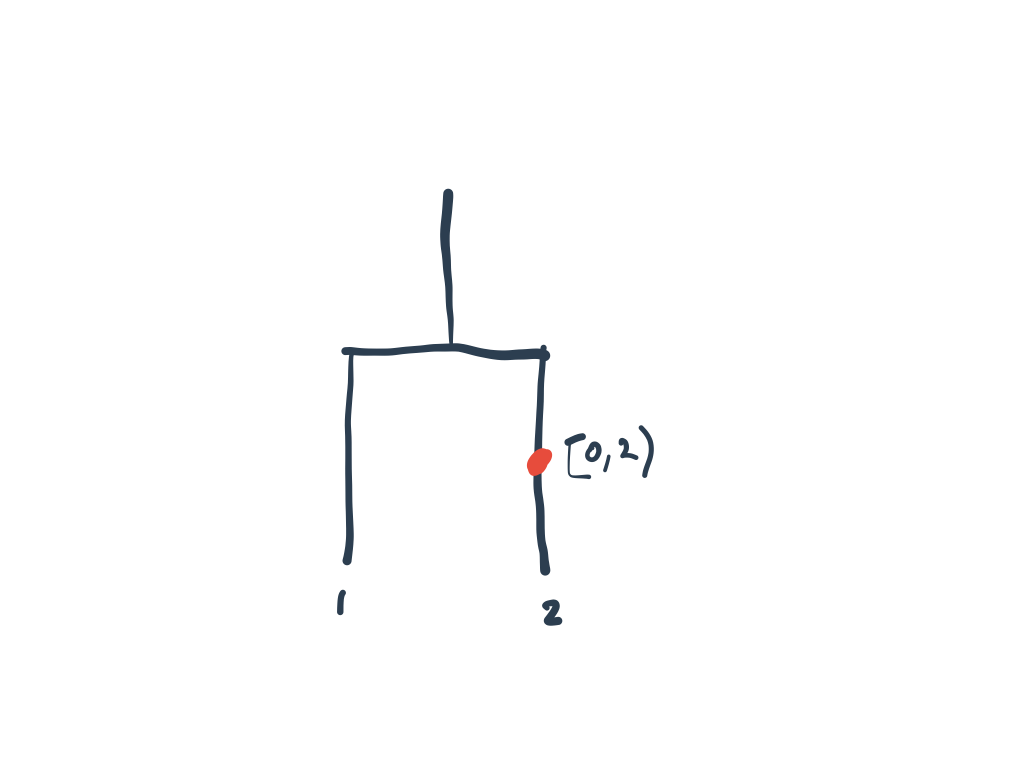

Now we know that the ARG is going to look something like this:

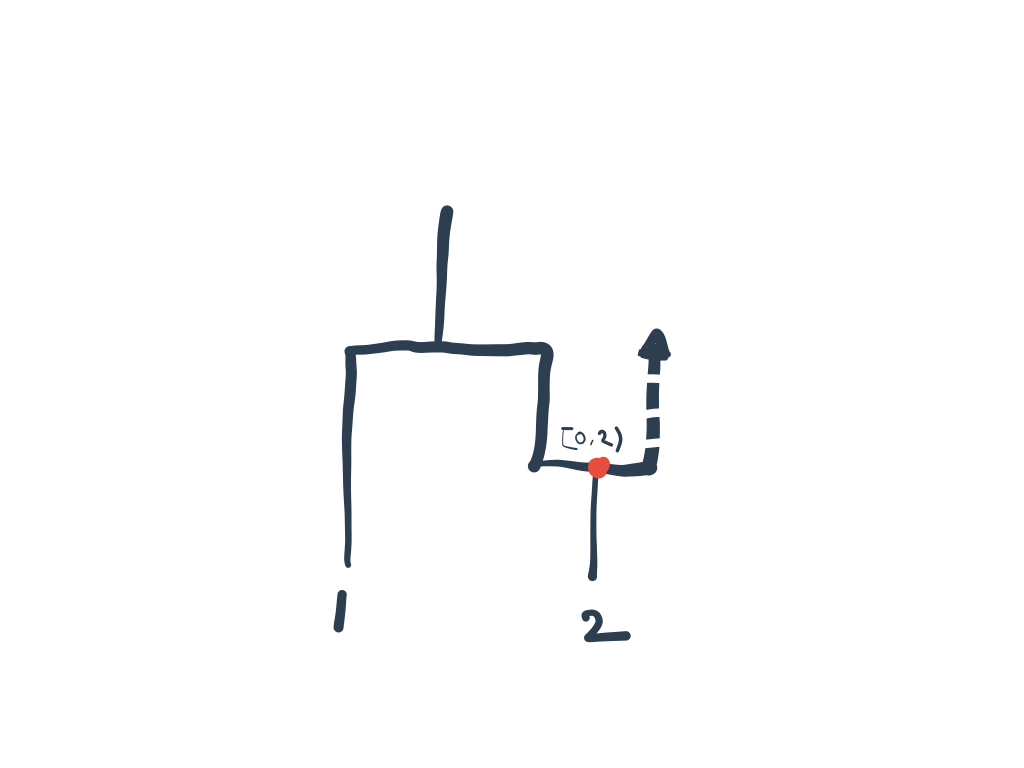

What happens to the floating lineage? Intuitively, it must follow the same coalescent process dynamics. That is, it "floats" backward in time, coalescing with each remaining lineage at rate 1. Suppose it coalesces above the existing TMRCA. Then the resulting ARG looks like:
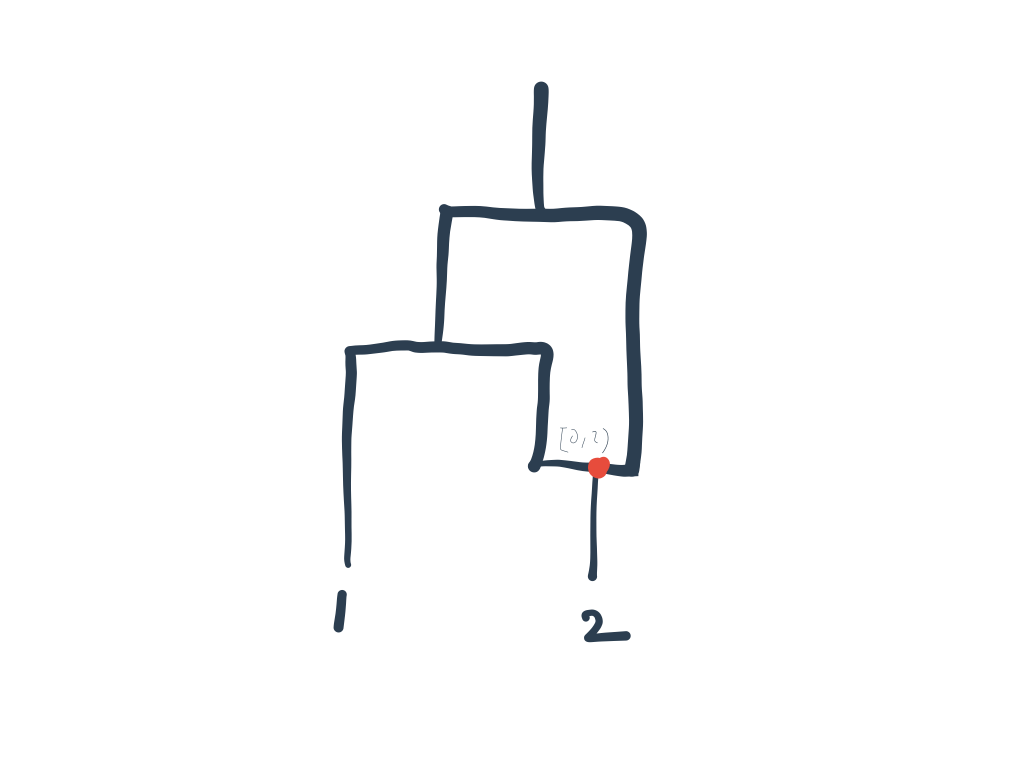

Thus, using the spatial algorithm, we have generated an ARG containing two trees:
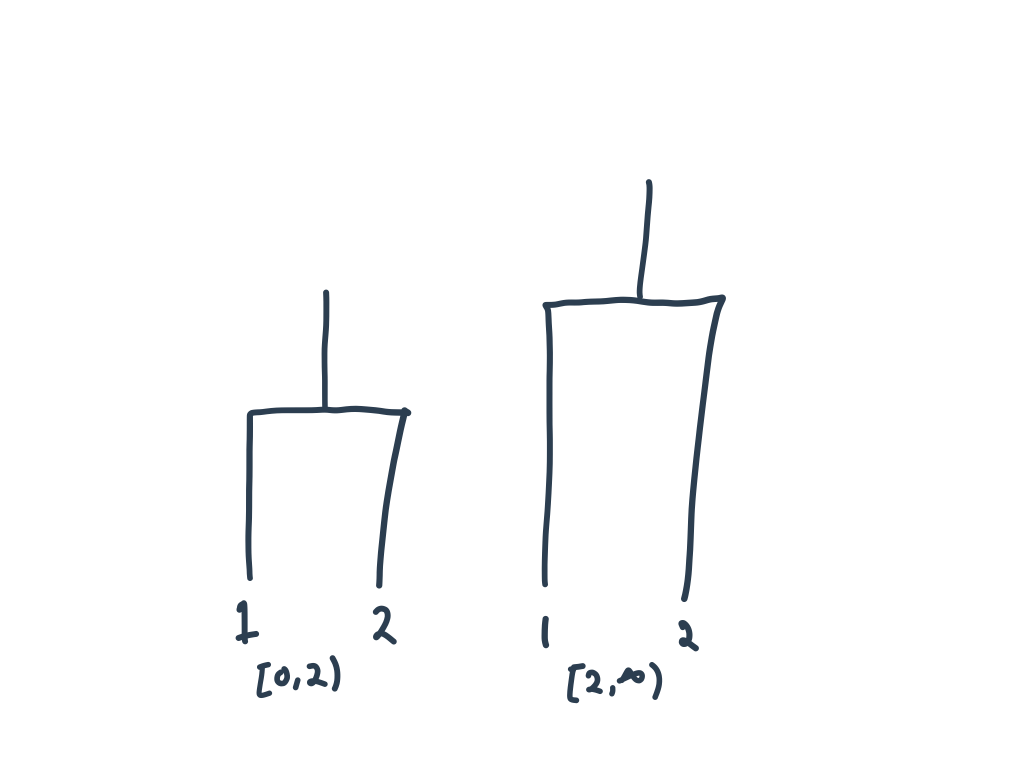

We could continue in this way, adding more recombination events and creating a progressively larger ARG:
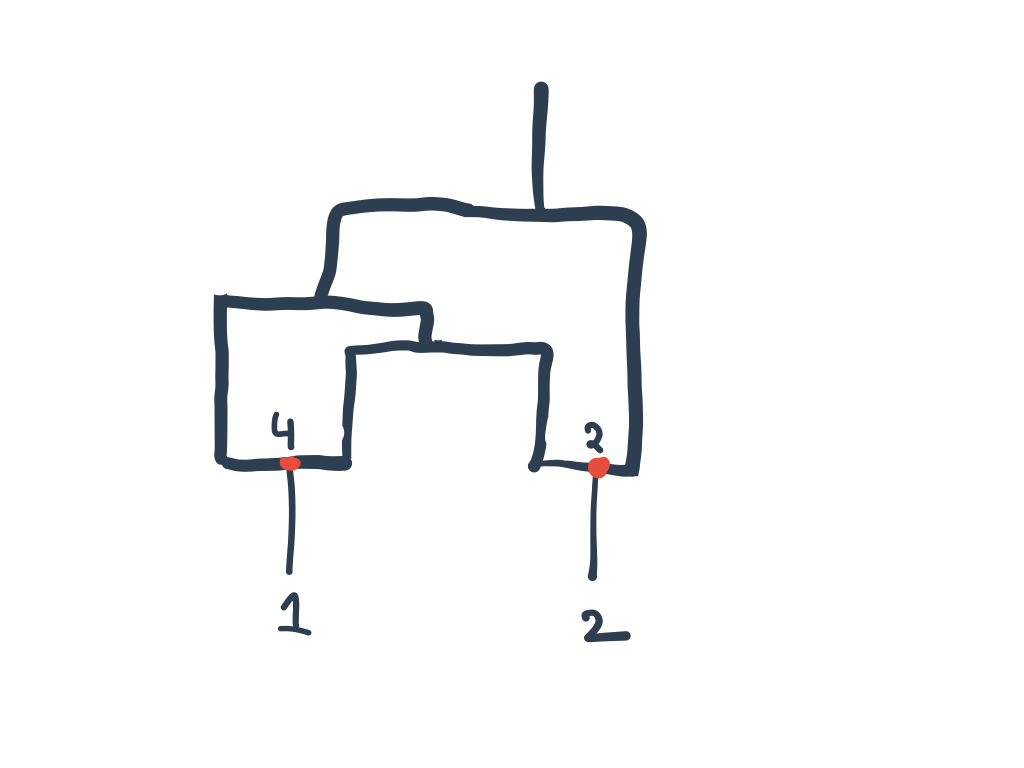
There are now 3 trees contained in the this graph: one for positions $[0,2)$, another for positions $[2,4)$, and the third for $[4,\infty)$.

Notice that this structure gets more and more complicated as we move from left to right. We keep adding more branches to the graph, and consequently recombination events become *more* frequent the farther along the sequence we get.

Is the sequence of trees Markov? Can we throw away old portions of the tree? Technically, the answer is no:
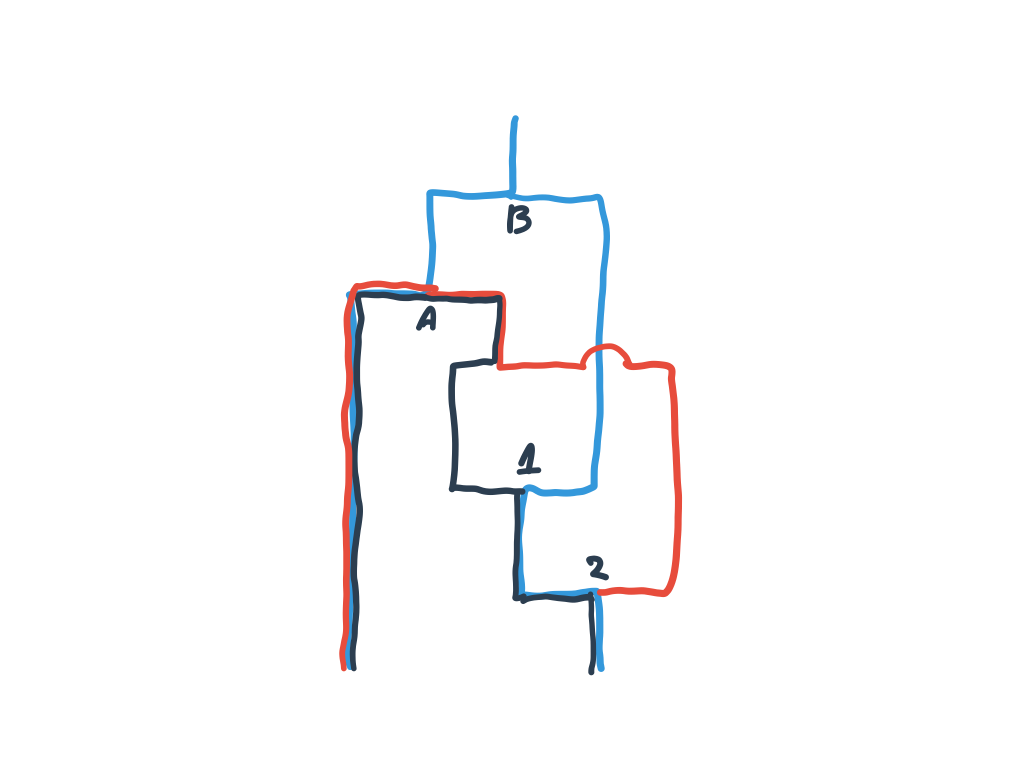

Consider the above tree, which has two samples, and spans positions $[0,3)$, with recombinations at positions $1$ and $2$. The tree for positions $[0,1)$ is shown in black, the tree for $[1,2)$ in <span style="color: rgb(52,152,219);">blue</span>, and the tree for positions $[2,3)$ in <span style="color: rgb(231,76,60)">red</span>. Positions $[0,1)\cup[2,3)$ have an MRCA at point A, while $[1,2)$ has an MRCA at point B. If we ignored the black tree, and just generated the tree for $[2,3)$ conditional on the one for $[1,2)$, then the probability that $[2,3)$ would have MRCA A is zero.

## The sequentially Markov coalescent (SMC)
Nevertheless, it's tempting to assume the tree sequence is Markov, because we have many tools for working with Markov chains. This is the idea of the sequentially Markov coalescent (McVean & Cardin 2005, Marjoram & Wall 2006). Again, it's easiest to illustrate this process for two chromosomes:

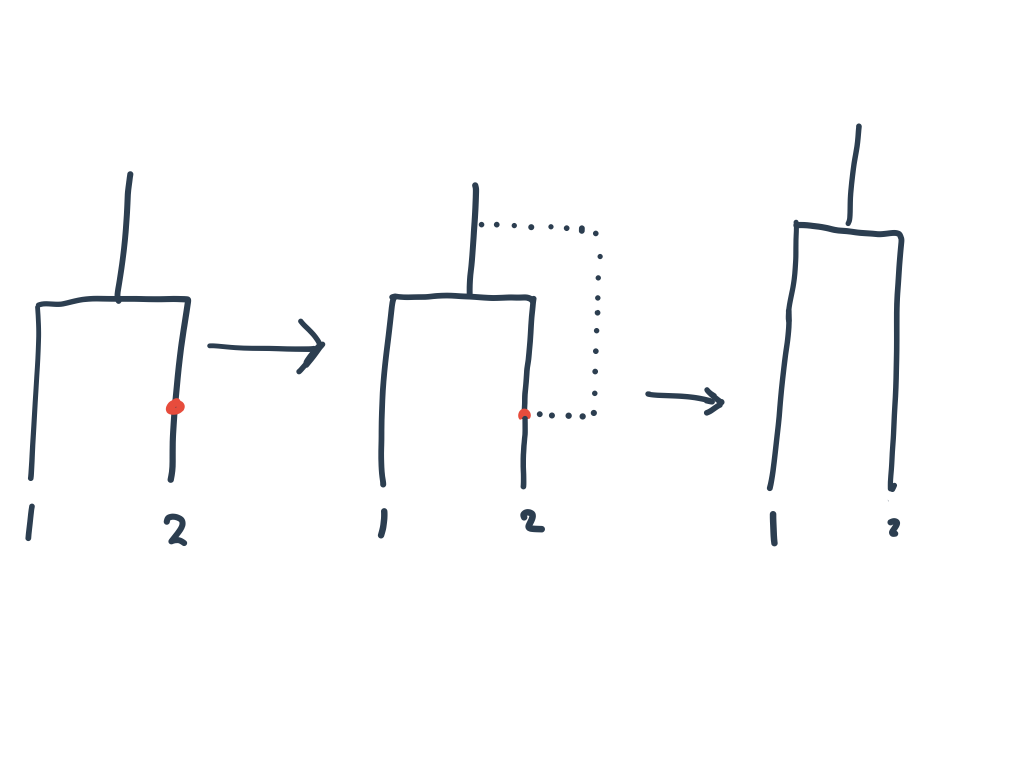

To obtain one tree from the preceding one, I first drop a recombination breakpoint, detach the subtree subtended by that breakpoint, and reattach it somewhere else. (This is called a [subtree prune and regraft](https://en.wikipedia.org/wiki/Tree_rearrangement).) Finally, I delete the portion of the tree between the recombination breakpoint and the new attachment point.

## Simulating the SMC
An advantage of the SMC is that it's easy to simulate, and unlike Hudson's or the spatial algorithm, it scales linearly in the sequence length.

In [140]:
import numpy as np
def simulate_smc(L, rho):
    '''Simulate a recombining sequence for sample size n=2 under the SMC.
    
    Args:
        L: sequence length
        rho: population scaled rate of recombination
        
    Returns:
        A list of the tree heights, and the positions they span
    '''
    x = np.random.exponential()  # height of current tree
    trees = [([None,0], None)]  # nonsense initial value
    ell = 0
    while ell < L:
        # sample distance along sequence to next recombination break point
        delta = min(np.random.exponential(scale=1 / (rho * x)), L - ell)
        # next sample height of recombination event
        r = np.random.uniform(0, x)
        q = x - r
        # the broken lineage recombines at rate 2 between r and x
        z = np.random.exponential(2 * q)
        if z < q:
            # if recombination happens below x, then w.p. 1/2 it coalesces 
            # onto the other lineage, else it is silent.
            if np.random.rand() < .5:
                trees.append(([trees[-1][0][1], ell+delta], x))
                x = r + z
        else:
            trees.append(([trees[-1][0][1], ell+delta], x))
            x += np.random.exponential()
        ell += delta
    return trees[1:]

In [143]:
L = 1_000_000
trees = simulate_smc(L, rho=1e-5)
trees[:3]

[([0, 88439.9729261641], 0.7099745672711424),
 ([88439.9729261641, 212895.39976022302], 4.016818853367624),
 ([212895.39976022302, 257893.5362901026], 3.994331818978318)]

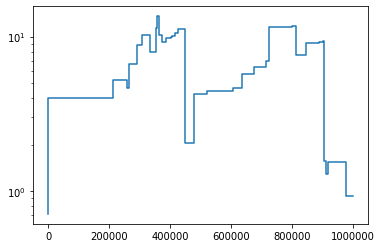

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_trees(trees):
    x = [a for (a, _), _ in trees]
    y = [x for _, x in trees]
    x.append(trees[-1][0][1])
    y.append(y[-1])
    plt.step(x, y)
    plt.yscale('log')
plot_trees(trees)

## Simulating genomes
Given a sequence of trees, it is easy to simulate mutation data. The number of mutations on a tree with branch length $\tau$ spanning an interval $[a,b)$ is Poisson with rate $\theta(b-a)\tau$, and given this number, they are uniformly distributed along the sequence.

In [174]:
def gen_mutations(trees, theta):
    mut_pos = []
    for (a, b), h in trees:
        m = np.random.poisson(theta * h * (b - a))
        mut_pos += np.random.uniform(a, b, m).tolist()
    return np.sort(mut_pos)
mut_pos = gen_mutations(trees, 1e-4)

It's fun to overlay these:

<BarContainer object of 99 artists>

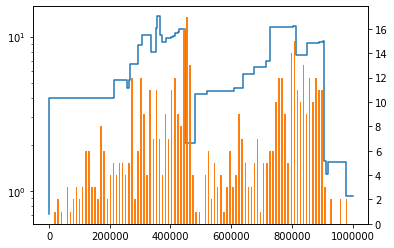

In [175]:
plot_trees(trees)
ax = plt.twinx()
y, x = np.histogram(mut_pos, np.linspace(0, L, 100))
ax.bar(x[:-1], y, width=L // 200, color='tab:orange')